In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
# Read csv and add header
data = pd.read_csv('RadarChuvaJan2021-6d.csv', 
        header=0, names=['day', 'DBZH', 'DBZV', 'KDP', 'ZDR', 'RHOHV', 'Tp_est'])

In [8]:
# Create a copy DF and ignore all rows where Tp_est is 0
pluvi_df = data.loc[data['Tp_est'] != 0]

# Fill Tp_est NaN values with 0 and remove all of them
pluvi_df['Tp_est'].fillna(0, inplace=True)
pluvi_df = pluvi_df.loc[pluvi_df['Tp_est'] != 0]

/tmp/ipykernel_11512/1538564358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pluvi_df['Tp_est'].fillna(0, inplace=True)


In [9]:
pluvi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12525 entries, 9 to 107110
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     12525 non-null  object 
 1   DBZH    5197 non-null   float64
 2   DBZV    4623 non-null   float64
 3   KDP     2266 non-null   float64
 4   ZDR     12525 non-null  float64
 5   RHOHV   12525 non-null  float64
 6   Tp_est  12525 non-null  float64
dtypes: float64(6), object(1)
memory usage: 782.8+ KB


### Dataset structure
* total rows: **107,135**
* rows where Tp_est is not *zero*: **13,998** -> data we will use
* rows excluded: **93,137**

In [10]:
def create_model(df: pd.DataFrame):
    # data setup
    X = np.array(df.drop(['day', 'Tp_est'], axis=1))
    y = np.array(df['Tp_est'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = preprocessing.MaxAbsScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    # train model
    model = DecisionTreeRegressor(max_depth=5)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # show metrics
    print('mse: ', mean_squared_error(y_test, predictions))
    print('mae: ', mean_absolute_error(y_test, predictions))
    
    # show dispersion plot
    data = pd.DataFrame({'y_test': y_test, 'predictions': predictions})
    sns.set_theme()
    sns.scatterplot(data=data, x="y_test", y="predictions").set_title('Dispersion Plot')

# Tests

### Drop NaN (Best Result)
* total rows after removing all NaN: **1664**

mse:  3.494194007736077
mae:  0.9822271515996978


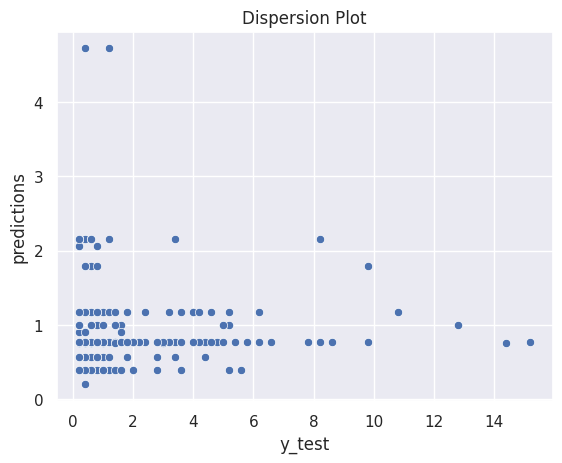

In [11]:
pluvi_df_nan = pluvi_df.dropna()
create_model(pluvi_df_nan)

### Replace NaN with Mean, Median and Zero

#### Fill NaN with Mean

/tmp/ipykernel_11512/3145835032.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pluvi_df_mean = pluvi_df.fillna(pluvi_df.mean())


mse:  4.0699328204349055
mae:  1.1485205048229123


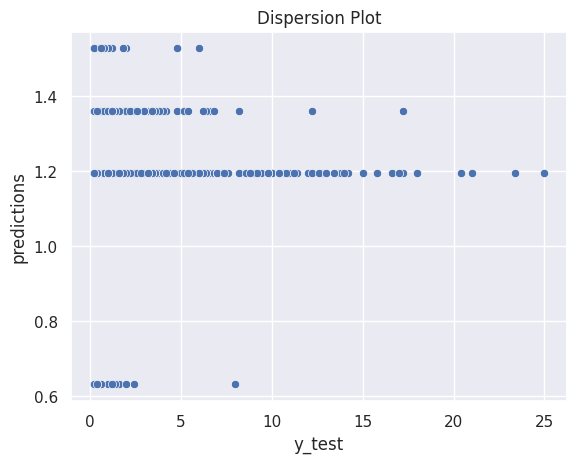

In [12]:
pluvi_df_mean = pluvi_df.fillna(pluvi_df.mean())
create_model(pluvi_df_mean)

#### Fill NaN with Zero

mse:  4.20338048342884
mae:  1.1229067436025595


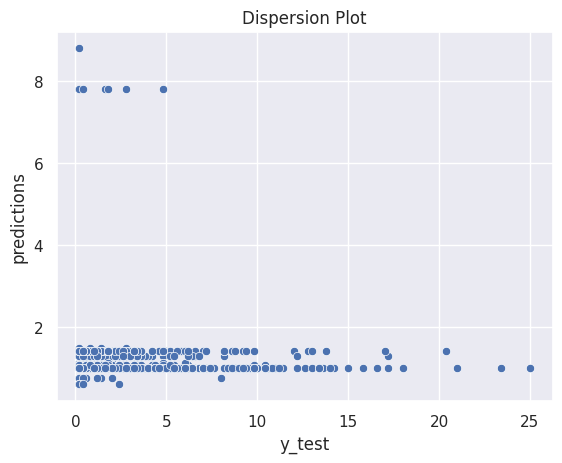

In [13]:
pluvi_df_mean = pluvi_df.fillna(0)
create_model(pluvi_df_mean)

#### Fill NaN with KNN Value Imputer

In [14]:
imputer = KNNImputer(n_neighbors=3)
df = pd.DataFrame(imputer.fit_transform(
    pluvi_df[['DBZH', 'DBZV', 'KDP', 'ZDR', 'RHOHV']]), columns = ['DBZH', 'DBZV', 'KDP', 'ZDR', 'RHOHV'])

mse:  4.491901981709701
mae:  1.2544708508628668


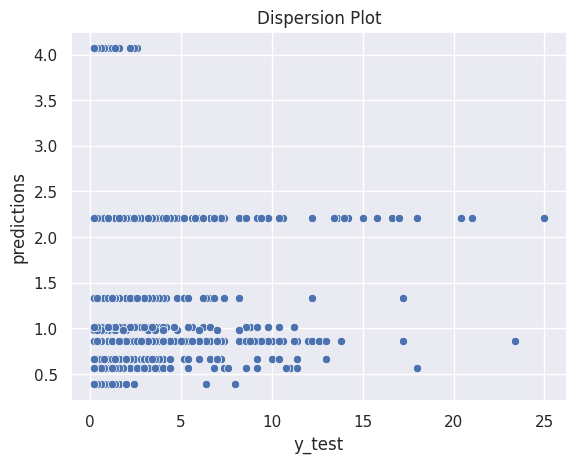

In [15]:
knn_df = df.copy()
knn_df['Tp_est'] = pluvi_df['Tp_est'].values
knn_df['day'] = pluvi_df['day'].values
create_model(knn_df)

# Run